In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import MultipleLocator, MaxNLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib import rcParams
from matplotlib import rc_context

# Seed
np.random.seed(1)

# Print precision
np.set_printoptions(precision=3)

# Text box properties
text_bbox = dict(boxstyle='round',
                 facecolor=(1., 1., 1., 1.),
                 edgecolor='k',
                 pad=0.5)

# Colours
colours = [plt.cm.tab10(i) for i in range(10)]

Gaussian process library [GPy](https://sheffieldml.github.io/GPy/) used in this notebook:

In [2]:
import GPy as gpy

# Gaussian processes

## Sampling a GP

A Gaussian process (GP) is an infinite-dimensional Gaussian distribution. A great Jupyter notebook by [Andreas Damianou](http://adamian.github.io/talks/Brown2016.html) (2016) gives an intuitive, step-by-step explanation of this idea.

In this notebook we only consider input dimension $d=1$. The the RBF kernel (Eq. 6.2) then takes the form:
$$
k_{\mathrm{RBF}}(x,x') = \eta^2 e^{-\frac{(x-x')^2}{2\ell^2}}
$$

Below are samples from the RBF kernel:

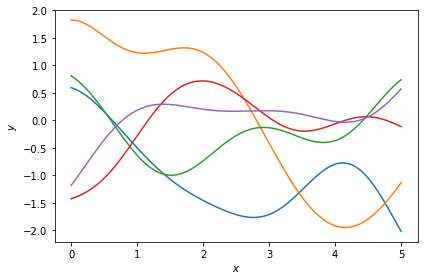

In [3]:
def createSamples(kernel):
    # Input space between 0 and 1
    numX = 1000
    X = np.linspace(0., 5., numX)
    # X must be a 2D array
    X = np.atleast_2d(X).T

    # Mean
    mu = np.zeros(numX)
    # Covariance
    C = kernel.K(X, X)
    # 5 random samples from GP
    samples = np.random.multivariate_normal(mu, C, 5)
    
    return X, samples

# RBF kernel
kernel = gpy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
X, samples = createSamples(kernel)

fig, ax = plt.subplots(1, 1)

for sample in samples:
    ax.plot(X, sample)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

fig.tight_layout()

Below we can see the effect of changing the parameters of the kernel:

## Changing kernel parameters (Figure 6.1)

Below are five samples each, for kernels with different parameters. The **GP mean** (here always 0) and **confidence intervals** (shaded blue areas) give the mean and the spread of these samples. The shaded blue areas give the $\mathbf{1\sigma}$ confidence intervals for the GP, i.e. we would expect the samples to lie within these areas about 68% of the time.

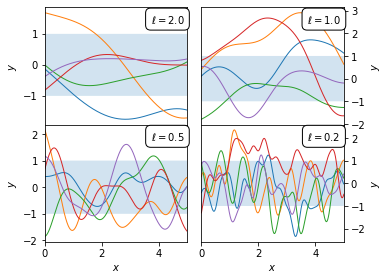

In [9]:
# Fix seed to 1 here in order to reproduce plot exactly as it appears in the thesis
np.random.seed(1)

variances = [1., 1., 1., 1.]
lengthscales = [2., 1., 0.5, 0.2]

fig, axs = plt.subplots(2, 2, sharex=True,
                        figsize=(5.5, 4.),
                        gridspec_kw={'hspace': 0})

for ax, sigma2, l in zip(np.ravel(axs), variances, lengthscales):
    kernel = gpy.kern.RBF(input_dim=1, variance=sigma2, lengthscale=l)
    X, samples = createSamples(kernel)
    
    for i, sample in enumerate(samples):
        ax.plot(X, sample, c=colours[i], lw=1.)
    
    ax.fill_between(X.ravel(), -1.*np.sqrt(sigma2), 1.*np.sqrt(sigma2), alpha=0.2)
    
    ax.text(0.86, 0.9,
            fr'$\ell={l}$',
            bbox=text_bbox,
            ha='center', va='center',
            transform=ax.transAxes)
    
    ax.set_ylabel(r'$y$')
    
    ax.set_xlim([0., 5.])
    ax.yaxis.set_major_locator(MultipleLocator(1.))

# x-axis label for bottom subplot only
for ax in axs[-1,:]:
    ax.set_xlabel(r'$x$')

# y-axis labels for right column on right
for ax in axs[:,1]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

for i in range(axs.shape[1]):
    fig.align_ylabels(axs[i,0])

fig.tight_layout()
fig.savefig('prior.pdf')

Decreasing $\ell$ makes the samples oscillate more rapidly. If, for example, we were to increase $\eta^2$ by a factor of 100, we would obtain samples that have a typical magnitude about 10x larger.

# GPs for regression

 ## Changing kernel parameters

It is possible to constrain a GP at a number of inputs $x$, and perform the same sampling. The confidence intervals will now tell us about the spread of possible functions that pass through these points. Shown below are samples (faint colours), the GP mean (solid blue line), and the $\mathbf{2\sigma}$ confidence intervals (shaded blue areas), each for the a different set of kernel parameters. Here the confidence intervals are telling us the expected distribution of possible functions that pass through the points.

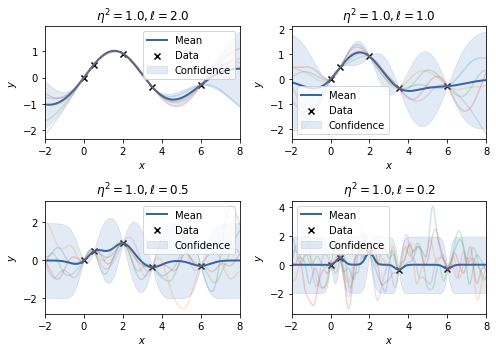

In [5]:
X_train = np.array([0., 0.5, 2., 3.5, 6.]).reshape(-1, 1)
Y_train = np.sin(X_train)

fig, axs = plt.subplots(2, 2, figsize=(7., 5.))
for ax, sigma2, l in zip(np.ravel(axs), variances, lengthscales):
    kernel = gpy.kern.RBF(input_dim=1, variance=sigma2, lengthscale=l)
    GPModel = gpy.models.GPRegression(X_train, Y_train, kernel)
    # We assume here that data are noiseless --> fix Gaussian noise ("nugget") to 0
    GPModel.Gaussian_noise.variance.fix(0.)
    
    # We make use of the inbuilt plot function for GPy models to quickly plot
    GPModel.plot(plot_limits=[-2, 8.], ax=ax)
    
    # Plot samples from "posterior"
    numSamples = 5
    XSample = np.linspace(-2., 8., 1000).reshape(-1, 1)
    posteriorSamples = GPModel.posterior_samples_f(XSample, full_cov=True, size=numSamples)
    for i in range(numSamples):
        ax.plot(XSample, posteriorSamples[:,:,i], alpha=0.2)
    
    ax.set_title(fr'$\eta^2 = {sigma2}, \ell = {l}$')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')

fig.tight_layout()

## Optimising kernel parameters (Figure 6.2)

Below we optimise kernel parameters by maximising the likelihood.

 /home/matt/anaconda3/envs/gp/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


eta^2 = 0.602, l = 1.063


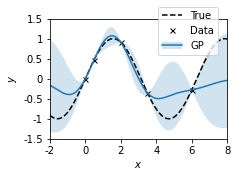

In [6]:
GPModel.Gaussian_noise.variance.fix(0.)
# Multiple restarts to optimization - likelihood surface often has multiple local maxima
GPModel.optimize_restarts(verbose=False)

# Obtain optimized kernel parameters
l = GPModel.rbf.lengthscale.values[0]
sigma2 = np.sqrt(GPModel.rbf.variance.values[0])
print(f'eta^2 = {sigma2:.3f}, l = {l:.3f}')

fig, ax = plt.subplots(1, 1, figsize=(3.4, 2.5))

# Plot original sine function
X_sin = np.linspace(-2., 8., 1000)
Y_sin = np.sin(X_sin)
trueHandle = ax.plot(X_sin, Y_sin, 'k--', label='True')[0]

# Plot data/training points
dataHandle = ax.plot(X_train, Y_train, 'kx', ms=5., label='Data')[0]

# Plot GP mean and 2-sigma confidence intervals
GPmean, GPcov = GPModel.predict_noiseless(np.atleast_2d(X_sin).T)
lower = GPmean - 2.*np.sqrt(GPcov)
higher = GPmean + 2.*np.sqrt(GPcov)

meanHandle = ax.plot(X_sin, GPmean, c=colours[0], ls='-')[0]
sigmaHandle = ax.fill_between(X_sin, lower.T[0], higher.T[0],
                color=colours[0], alpha=0.2, lw=0.)

ax.set_xlim([-2, 8.])
ax.set_ylim([-1.5, 1.5])

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

ax.xaxis.set_major_formatter(FormatStrFormatter('%g')) # No unnecessary trailing decimals
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

ax.legend([trueHandle, dataHandle, (sigmaHandle, meanHandle)],
          ['True', 'Data', 'GP'],
          loc=(0.61, 0.7))

fig.tight_layout()
fig.savefig('GP_regression.pdf')

## Sampling the optimised GP

As in all previous figures, we can draw samples from this newly-optimised GP.

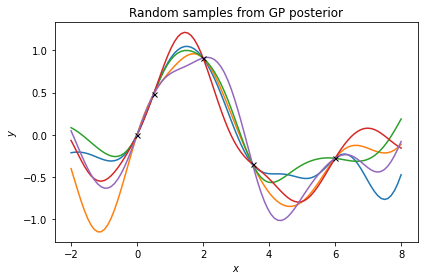

In [7]:
X = np.linspace(-2., 8., 100).reshape(-1, 1)
posteriorSamples = GPModel.posterior_samples_f(X, full_cov=True, size=5)

fig, ax = plt.subplots(1, 1)

for i in range(posteriorSamples.shape[2]):
    ax.plot(X, posteriorSamples[:,:,i])
ax.plot(X_train, Y_train, 'kx', ms=5.)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title('Random samples from GP posterior')
fig.tight_layout()

## Using a non-zero "nugget" component in the kernel

The case with a non-zero "nugget" / Gaussian noise for each data point (we use here the 1D equivalent of kernel given in Eq. 6.4 of the thesis, and explained in Sec. 6.2.1):

Optimization restart 1/10, f = 3.5070571835468294
Optimization restart 2/10, f = 3.5070571835483175
Optimization restart 3/10, f = 3.507057184169997
Optimization restart 4/10, f = 3.6420185908785725
Optimization restart 5/10, f = 3.5070571835463586
Optimization restart 6/10, f = 3.5070571835476483
Optimization restart 7/10, f = 3.64201859085395
Optimization restart 8/10, f = 3.642018590854088
Optimization restart 9/10, f = 3.507057183568184
Optimization restart 10/10, f = 3.5070571835462276


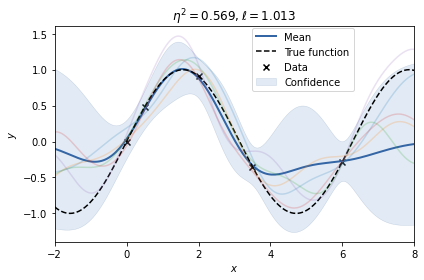

In [8]:
# Fix Gaussian noise variance ("nugget") to 0.01 --> sigma_n of 0.1
GPModel.Gaussian_noise.variance.fix(0.01)

# Multiple restarts to optimization - likelihood surface often has multiple local maxima
GPModel.optimize_restarts()

# Optimized kernel parameters
l = GPModel.rbf.lengthscale.values[0]
sigma2 = np.sqrt(GPModel.rbf.variance.values[0])

# Plot
fig, ax = plt.subplots(1, 1)

GPModel.plot(plot_limits=[-2, 8.], ax=ax)
ax.plot(X_sin, Y_sin, 'k--', label='True function')

# Plot samples from "posterior"
numSamples = 5
XSample = np.linspace(-2., 8., 1000).reshape(-1, 1)
posteriorSamples = GPModel.posterior_samples_f(XSample, full_cov=True, size=numSamples)
for i in range(numSamples):
    ax.plot(XSample, posteriorSamples[:,:,i], alpha=0.2)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend(loc=(0.55, 0.7))
ax.set_title(fr'$\eta^2 = {sigma2:.3f}, \ell = {l:.3f}$')

fig.tight_layout()

At each training point, the $2\sigma$ confidence intervals shrink to a minimum of $2\sigma_{n}$, here $0.2$. (In the zero-nugget case they shrink to 0.)